# AIMLCZG567_Assignment_1_Group_18


                          
| Name            | BITS_ID     | Contribution |
|-----------------|-------------|--------------|
| Rahul           | 2024ad05284 | 100%         |
| Ankita Yadav    | 2024AC05681 | 100%         |
|Rasampreet Singh |             | 100%         |
|Srinidhi S       | 2024AC05595 | 100%         |



In [1]:
import pandas as pd
import numpy as np
import requests
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
import time

# ML Imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight
from scipy.sparse import hstack
import joblib
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

## LOAD CISA KEV DATA

In [2]:
def load_cisa_kev():
    print("Loading CISA KEV data...")
    url = "https://www.cisa.gov/sites/default/files/feeds/known_exploited_vulnerabilities.json"
    data = requests.get(url).json()
    kev_df = pd.DataFrame(data['vulnerabilities'])
    kev_ids = set(item['cveID'] for item in data['vulnerabilities'])
    print(f"Loaded {len(kev_ids)} exploited CVEs from CISA. Sample....")
    print(kev_df.head())

    return kev_ids, kev_df

## Fetch CVEs from NVD

In [3]:
def fetch_cves(start_date="2025-01-01", end_date="2025-04-30", results_per_page=2000, apikey= None)-> pd.DataFrame:
    """
    Fetch CVEs from NVD API within a given date range.

    Args:
        start_date (str): Start date in YYYY-MM-DD format.
        end_date (str): End date in YYYY-MM-DD format.
        Note : The maximum allowable range when using any date range parameters is 120 consecutive days.
        results_per_page (int): Number of results per page (max 2000).


    Returns:
        list: A Data frame of CVE items.
    """
    print("\n Fetching CVEs for given date range...")
    base_url = f"https://services.nvd.nist.gov/rest/json/cves/2.0/?pubStartDate={start_date}T00:00:00.000&pubEndDate={end_date}T00:00:00.000"
    headers = {"apiKey" : apikey}

    all_cves = []
    start_index = 0

    while True:
        url = f"{base_url}&startIndex={start_index}&resultsPerPage={results_per_page}"
        response = requests.get(url, headers = headers )

        if response.status_code != 200:
            raise Exception(f"Error fetching data: {response.status_code} - {response.text}")

        data = response.json()
        cves = data.get("vulnerabilities", [])
        all_cves.extend(cves)

        # Check if there are more pages
        total_results = data.get("totalResults", 0)
        start_index += results_per_page

        if start_index >= total_results:
            break

    print(f"Loaded {len(all_cves)} CVEs from NVD. Sample....")
    fetched_cve_df = pd.DataFrame(all_cves)
    print(fetched_cve_df.head())
    return fetched_cve_df

## Flatten CVEs data

In [4]:
def flatten_cve(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Flatten the NVD 'vulnerabilities' structure from the DataFrame returned by fetch_cves.

    Parameters
    ----------
    df_raw : pd.DataFrame
        DataFrame returned by fetch_cves. Expected to have a column 'cve' with dicts.

    Returns
    -------
    pd.DataFrame
        Flattened DataFrame with selected NVD CVE fields.
    """
    if "cve" not in df_raw.columns:
        raise ValueError("Input df_raw must have a 'cve' column containing NVD CVE dicts.")

    # Normalize the nested 'cve' objects
    df_cve = pd.json_normalize(df_raw["cve"], sep=".")

    # --- Ensure expected columns exist ---
    for col, default in [
        ("descriptions", []),
        ("metrics", {}),
        ("weaknesses", []),
        ("configurations", []),
        ("references", []),
    ]:
        if col not in df_cve.columns:
            df_cve[col] = [default] * len(df_cve)

    # --- Utilities ---
    def _pick_english_description(descriptions):
        if isinstance(descriptions, list):
            for d in descriptions:
                if d.get("lang", "").lower() == "en":
                    return d.get("value")
            return descriptions[0].get("value") if descriptions else None
        return None

    def _extract_cvss(metrics):
        """
        Prefer v3.1, then v3.0, then v2. Returns dict with basic fields only.
        """
        out = {
            "cvss_version": None,
            "cvss_score": None,
            "cvss_severity": None,
            "cvss_vector": None,
            "exploitability_score": None,
            "impact_score": None,
        }
        if not isinstance(metrics, dict):
            return out

        def pick(metric_list, version_label):
            if isinstance(metric_list, list) and metric_list:
                m = metric_list[0]
                data = m.get("cvssData", {})
                return {
                    "cvss_version": version_label,
                    "cvss_score": data.get("baseScore"),
                    "cvss_severity": data.get("baseSeverity"),
                    "cvss_vector": data.get("vectorString"),
                    "exploitability_score": m.get("exploitabilityScore"),
                    "impact_score": m.get("impactScore"),
                }
            return None

        for key, label in [("cvssMetricV31", "3.1"), ("cvssMetricV30", "3.0"), ("cvssMetricV2", "2.0")]:
            candidate = pick(metrics.get(key), label)
            if candidate:
                return candidate
        return out

    def _extract_cwes(weaknesses):
        """
        Collect CWE identifiers (e.g., 'CWE-79') from weaknesses[].description[].value
        """
        cwes = []
        if isinstance(weaknesses, list):
            for w in weaknesses:
                for d in w.get("description", []):
                    val = d.get("value")
                    if val and "CWE-" in val:
                        cwes.append(val)
        cwes = sorted(set(cwes))
        return ";".join(cwes) if cwes else None

    def _parse_cpe23_uri(cpe_uri):
        # cpe:2.3:<part>:<vendor>:<product>:<version>:<update>:<edition>:<language>:...
        try:
            parts = cpe_uri.split(":")
            return {
                "cpe_part": parts[2] if len(parts) > 2 else None,     # 'a','o','h'
                "cpe_vendor": parts[3] if len(parts) > 3 else None,
                "cpe_product": parts[4] if len(parts) > 4 else None,
                "cpe_version": parts[5] if len(parts) > 5 else None,
            }
        except Exception:
            return {"cpe_part": None, "cpe_vendor": None, "cpe_product": None, "cpe_version": None}

    def _extract_affected_software(configurations):
        """
        Aggregate vendors/products/versions/part categories from configurations[].cpeMatch[].
        """
        vendors, products, versions, parts = set(), set(), set(), set()
        if not isinstance(configurations, list):
            return {
                "affected_vendors": None,
                "affected_products": None,
                "affected_versions": None,
                "affected_part_categories": None,
            }
        for node in configurations:
            for match in node.get("cpeMatch", []):
                cpe = match.get("criteria") or match.get("cpe23Uri")
                if not cpe:
                    continue
                parsed = _parse_cpe23_uri(cpe)
                v, p, ver, part = parsed["cpe_vendor"], parsed["cpe_product"], parsed["cpe_version"], parsed["cpe_part"]
                if v: vendors.add(v)
                if p: products.add(p)
                if ver and ver not in {"*", "-"}:  # filter placeholders
                    versions.add(ver)
                if part:
                    parts.add({"a": "application", "o": "operating_system", "h": "hardware"}.get(part, part))
        return {
            "affected_vendors": ";".join(sorted(vendors)) if vendors else None,
            "affected_products": ";".join(sorted(products)) if products else None,
            "affected_versions": ";".join(sorted(versions)) if versions else None,
            "affected_part_categories": ";".join(sorted(parts)) if parts else None,
        }

    def _extract_reference_features(refs):
        """
        Basic counts of references and tags (no binarization or leakage handling here).
        """
        n_refs = 0
        n_exploit = 0
        n_patch = 0
        n_vendor_adv = 0
        has_exploit_tag = 0
        if isinstance(refs, list):
            for r in refs:
                n_refs += 1
                tags = [t.lower() for t in (r.get("tags") or [])]
                if "exploit" in tags:
                    n_exploit += 1
                    has_exploit_tag = 1
                if "patch" in tags:
                    n_patch += 1
                if "vendor advisory" in tags:
                    n_vendor_adv += 1
        return {
            "references_count": n_refs,
            "references_exploit_count": n_exploit,
            "references_patch_count": n_patch,
            "references_vendor_advisory_count": n_vendor_adv,
            "has_exploit_tag": has_exploit_tag,
        }

    # --- Core fields ---
    df_cve["cve_id"] = df_cve.get("id")
    df_cve["published"] = pd.to_datetime(df_cve.get("published"), errors="coerce")
    df_cve["last_modified"] = pd.to_datetime(df_cve.get("lastModified"), errors="coerce")
    df_cve["vuln_status"] = df_cve.get("vulnStatus")

    # Descriptions
    df_cve["description"] = df_cve["descriptions"].apply(_pick_english_description)

    # CVSS
    cvss_series = df_cve["metrics"].apply(_extract_cvss)
    cvss_df = pd.DataFrame(cvss_series.tolist())
    df_cve = pd.concat([df_cve, cvss_df], axis=1)

    # CWE(s)
    df_cve["cwes"] = df_cve["weaknesses"].apply(_extract_cwes)

    # Affected software (CPE)
    affected_series = df_cve["configurations"].apply(_extract_affected_software)
    affected_df = pd.DataFrame(affected_series.tolist())
    df_cve = pd.concat([df_cve, affected_df], axis=1)

    # References
    refs_series = df_cve["references"].apply(_extract_reference_features)
    refs_df = pd.DataFrame(refs_series.tolist())
    df_cve = pd.concat([df_cve, refs_df], axis=1)

    # Final columns
    cols = [
        "cve_id",
        "published", "last_modified", "vuln_status",
        "cvss_version", "cvss_score", "cvss_severity", "cvss_vector",
        "exploitability_score", "impact_score",
        "cwes",
        "affected_part_categories", "affected_vendors", "affected_products", "affected_versions",
        "references_count", "references_exploit_count", "references_patch_count",
        "references_vendor_advisory_count", "has_exploit_tag",
        "description",
    ]
    existing_cols = [c for c in cols if c in df_cve.columns]
    flatten_cve_df = df_cve[existing_cols].copy()
    print("\n Flatten CVEs...")
    print(flatten_cve_df.head())
    return flatten_cve_df


## LABEL CVEs data

In [5]:
def label_cve_data(df, kev_ids):
    """
    Label a CVE 1 if it is present in KEV , 0 otherwsie
    """
    print("Labeling exploited vulnerabilities...")
    df['exploited'] = df['cve_id'].apply(lambda x: 1 if x in kev_ids else 0)
    print("\nClass Distribution:")
    print(df['exploited'].value_counts())

  # Pie chart
    counts = df['exploited'].value_counts()
    labels = ['Not Exploited', 'Exploited']
    sizes = [counts.get(0, 0), counts.get(1, 0)]
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
    plt.title('CVE Exploitation Distribution')
    plt.show()

    return df

## Cleaning Data

In [6]:
def clean_cve_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean raw labelled CVE dataframe from NVD+KEV.

    Expected columns:
    ['cve_id', 'published', 'last_modified', 'vuln_status',
     'cvss_score', 'cvss_severity', 'cvss_vector',
     'exploitability_score', 'impact_score',
     'references_count', 'references_exploit_count',
     'references_patch_count', 'references_vendor_advisory_count',
     'has_exploit_tag', 'description', 'exploited']
    """

    df = df.copy()

    # --- Basic sanity cleanup ---

    # (A) Drop rows without CVE id or description
    df = df.dropna(subset=['cve_id', 'description'])

    # (B) Parse datetime columns
    df['published'] = pd.to_datetime(df['published'], errors='coerce')
    df['last_modified'] = pd.to_datetime(df['last_modified'], errors='coerce')

    # (C) Drop rows where we completely failed to parse published date
    df = df.dropna(subset=['published'])

    # (D) Remove clearly unhelpful CVEs (e.g., Rejected)
    # Keep only actually analyzed/valid vulns
    valid_statuses = ['Analyzed', 'Modified', 'Undergoing Analysis']
    df = df[df['vuln_status'].isin(valid_statuses)]

    # (E) Deduplicate by CVE id: keep the latest version
    df = df.sort_values('last_modified').drop_duplicates(subset='cve_id', keep='last')

    # (F) Reset index for cleanliness
    df = df.reset_index(drop=True)

    return df


#### **Reasoning for the different Cleaning methods used:**

##### **(A) dropna(subset=['cve_id', 'description'])**
Removes rows where:  
1. cve_id is missing, or  
2. description is missing.

Missing cve_id → Can't be linked to KEV, can’t be used in analysis, can't dedupe, and is basically a broken row. Keeping it adds noise but no value.

Missing description → The description text is one of the main feature sources (TF-IDF, keywords like “RCE”, “authentication bypass”, etc.).  
A row with no description gives no text features and means that the NVD entry is incomplete.



##### **(B) Parsing datetime columns with pd.to_datetime(...)**
It converts strings like "2025-01-08 23:15:09.763" into real datetime objects.

The analysis cares about temporal characteristics and proper validations. We need features like  
1. age in days,  
2. published year/month,
3. “days between publication and last modification”.

The temporal validations require published and last_modified to be actual datetimes, not raw strings. Without parsing these as datetimes,it is difficult to analyse time-based split or temporal feature.


##### **(C) dropna(subset=['published'])**
 Removes rows where 'published' is missing or failed to parse.  
Temporal validation is key to avoiding data leakage.
A CVE cannot be correctly placed on a timeline if we have no information on when it was published.

So rows with no published date
1. cannot be used in a time-aware ML setup,
2. would force into hacks (e.g., treating them as 0 or current date — both bad).


##### **(D) df = df[df['vuln_status'].isin(valid_statuses)]**

**"Rejected", "Reserved", "Awaiting Analysis"** must be removed because these records are NOT real vulnerabilities, and keeping them destroys model validity.

1. Rejected CVEs
* They contain no CVSS score
* They can NEVER be exploited → label is always 0
* They create trivial negatives, inflating accuracy and breaking the model
Therefore they must be removed.

2. Reserved CVEs
* Description is generic
* No metadata
* Not released yet
* Impossible to model
These should also be removed.

3. Awaiting Analysis - NVD hasn’t filled the fields yet.
* Missing CVSS
* Missing CWE
* Missing products
* Often “skeleton” data  
These create noise.


##### **(E) drop_duplicates(subset='cve_id', keep='last') after sorting by last_modified**
NVD entries are mutable:
1. New CVSS scores may be added.
2. Additional references may appear.
3. Severity or CWE may be updated.

If we keep multiple rows per CVE:
1. It artificially overweights certain CVEs,
2. Inconsistent labels if something went wrong during labeling,
3. Evaluation could go wwrong (same CVE in both train and test).

So **deduping** by cve_id is about:
* data integrity (1 row per entity),
* avoiding leakage (no duplication across time splits),
* cleaner analysis.

##### **(F) reset_index(drop=True)**
Resetting makes:
* debugging easier,
* logs and .head() outputs cleaner,
* alignment with X / y consistency more obvious.


## Feature Engineering

In [7]:
def engineer_features(df: pd.DataFrame):
    """
    Engineer features for CVE exploitation prediction.

    Returns:
        X        : sparse matrix of features (text + numeric)
        y        : numpy array of labels (0/1)
        tfidf    : fitted TfidfVectorizer on description
        num_cols : list of numeric feature column names
    """
    df = df.copy()

    # ---------- Target ----------
    y = df['exploited'].astype(int).values

    # ---------- Temporal features ----------
    # Age of the record in days between publish and last_modified
    df['last_modified'] = pd.to_datetime(df['last_modified'], errors='coerce')
    df['published'] = pd.to_datetime(df['published'], errors='coerce')

    df['age_days'] = (df['last_modified'] - df['published']).dt.days
    df['age_days'] = df['age_days'].fillna(0).clip(lower=0)

    # Year and month of publication (can help with trend shifts)
    df['published_year'] = df['published'].dt.year
    df['published_month'] = df['published'].dt.month

    # ---------- CVSS-related numeric features ----------
    num_cols_raw = [
        'cvss_score',
        'exploitability_score',
        'impact_score',
        'references_count',
        'references_exploit_count',
        'references_patch_count',
        'references_vendor_advisory_count',
        'has_exploit_tag',
    ]

    # Make sure these are numeric
    for col in num_cols_raw:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        else:
            # If column missing, create it as 0
            df[col] = 0.0

    df[num_cols_raw] = df[num_cols_raw].fillna(0)

    # Encode cvss_severity into an ordinal numeric feature
    severity_map = {
        'NONE': 0,
        'LOW': 1,
        'MEDIUM': 2,
        'HIGH': 3,
        'CRITICAL': 4
    }
    df['cvss_severity_num'] = df['cvss_severity'].map(severity_map).fillna(0).astype(int)

    # Simple parsing of CVSS vector (e.g., "AV:N/AC:L/...")
    # Network vs Local etc.
    vec = df['cvss_vector'].fillna('')

    df['av_network'] = vec.str.contains('AV:N', na=False).astype(int)
    df['av_adjacent'] = vec.str.contains('AV:A', na=False).astype(int)
    df['av_local'] = vec.str.contains('AV:L', na=False).astype(int)
    df['av_physical'] = vec.str.contains('AV:P', na=False).astype(int)

    df['ac_low'] = vec.str.contains('AC:L', na=False).astype(int)
    df['ac_high'] = vec.str.contains('AC:H', na=False).astype(int)

    # ---------- Final numeric feature list ----------
    numeric_cols = (
        num_cols_raw +
        [
            'cvss_severity_num',
            'age_days',
            'published_year',
            'published_month',
            'av_network',
            'av_adjacent',
            'av_local',
            'av_physical',
            'ac_low',
            'ac_high',
        ]
    )

    X_num = df[numeric_cols].fillna(0).values

    # ---------- Text features (TF-IDF on description) ----------
    desc = (
        df['description']
        .fillna('')
        .str.replace(r'\s+', ' ', regex=True)
        .str.replace(r'[^a-zA-Z0-9 ]', ' ', regex=True)
        .str.lower()
    )

    tfidf = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        min_df=2
    )
    X_text = tfidf.fit_transform(desc)

    # ---------- Combine numeric + text ----------
    X = hstack([X_text, X_num]).tocsr()

    return X, y, tfidf, numeric_cols


### Summary of Feature Engineering

The feature engineering function creates three major feature groups
#### 1. TEXT FEATURES (TF-IDF on description)
* Bag-of-words and bi-grams from **description** are engineered
* Text contains the strongest attack intent signal.
* Exploited CVEs often include: “RCE”, “zero-click”, “unauthenticated”, “public exploit available”,  “Ivanti / Fortinet / Exchange”.
TF-IDF automatically captures this.

#### 2. NUMERIC FEATURES (Structured fields from NVD)
##### ➤ 2.1 CVSS & scoring metadata  

| Feature                | Why it matters                                        |
| ---------------------- | ----------------------------------------------------- |
| `cvss_score`           | Higher severity often correlates with exploitability. |
| `exploitability_score` | Direct predictor of ease-of-exploitation.             |
| `impact_score`         | Higher impact = higher attacker motivation.           |
| `cvss_severity_num`    | Encoded as NONE=0 → CRITICAL=4.                       |

##### ➤ 2.2 Reference-based features  

| Feature                            | Meaning                           | Why it matters                                     |
| ---------------------------------- | --------------------------------- | -------------------------------------------------- |
| `references_count`                 | How many sources mention this CVE | More attention → more likelihood of exploitation   |
| `references_exploit_count`         | Exploit links found in references | **VERY strong predictor**                          |
| `references_patch_count`           | Patch references                  | Patch availability can correlate with exploitation |
| `references_vendor_advisory_count` | Vendor security bulletins         | High-profile vendors = more attacks                |
| `has_exploit_tag`                  | Whether NVD auto-tagged exploit   | Direct exploitation signal                         |

##### ➤ 2.3 Temporal features  
| Feature           | Meaning                                                             |
| ----------------- | ------------------------------------------------------------------- |
| `age_days`        | Time between publication and last modification                      |
| `published_year`  | Captures trends (e.g., huge spike in 2023–2024 enterprise exploits) |
| `published_month` | Some months have seasonal attacker activity                         |

##### ➤ 2.4 CVSS Vector String features
| Feature       | Encodes                        |
| ------------- | ------------------------------ |
| `av_network`  | Attack Vector = Network (AV:N) |
| `av_adjacent` | AV:A                           |
| `av_local`    | AV:L                           |
| `av_physical` | AV:P                           |
| `ac_low`      | Attack Complexity low          |
| `ac_high`     | Attack Complexity high         |


#### 3. FINAL FEATURE MATRIX = [TF-IDF text features + numeric features]
* They are combined using X = hstack([X_text, X_num])  


##### Requirements - Analysis of CVSS scores, vulnerability types, affected software categories, temporal characteristics, description text

##### 1. CVSS Scores
The features include:
* cvss_score
* impact_score
* exploitability_score
* cvss_severity_num
* cvss_vector (parsed into: av_network, av_local, av_adjacent, av_physical and ac_low, ac_high)


##### 2. Vulnerability types
Implemented through TF-IDF text features (captures RCE, overflow, auth bypass, traversal, injection…)

##### 3. Affected software categories
Implemented through
* Vendor names implicitly captured in TF-IDF (e.g., Ivanti, Microsoft)
* 'affected_products' handled as text features

##### 4. Temporal characteristics
The features include:
* published_year
* published_month
* age_days

##### 5. Description text
The feature engineering includes:
* Cleaned description text
* TF-IDF with 5000 features
* Bigram support (captures phrases like “remote code”, “authentication bypass”)

##### 6. Handling severe class imbalance
The dataset has maybe 10–30 exploited CVEs out of ~2000 → extreme imbalance.
The pipeline is ready for:
* SMOTE
* class_weight="balanced"
* XGBoost scale_pos_weight
Hence, it fully supports imbalance handling.





## Train Test Split

In [8]:
def temporal_train_test_split(df, test_size=0.3):
    """
    Split data temporally: train on earlier CVEs, test on later CVEs.
    This mimics real-world deployment where you predict future exploitation.
    """
    df_sorted = df.sort_values('published').reset_index(drop=True)
    split_idx = int(len(df_sorted) * (1 - test_size))

    train_df = df_sorted.iloc[:split_idx]
    test_df = df_sorted.iloc[split_idx:]

    print(f"Temporal split: Train {len(train_df)} CVEs | Test {len(test_df)} CVEs")
    print(f"Train exploited: {train_df['exploited'].sum()} ({train_df['exploited'].mean():.1%})")
    print(f"Test exploited: {test_df['exploited'].sum()} ({test_df['exploited'].mean():.1%})")

    return train_df, test_df

## Training Model

In [9]:
def train_model(X_train, y_train, X_test=None, y_test=None):
    """
    Train Logistic Regression with class weighting and calibration for imbalanced data.
    """
    # Compute class weights for imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))

    print(f"Class weights: {class_weight_dict}")

    # Logistic Regression with L2 regularization and class weights
    base_model = LogisticRegression(
        random_state=SEED,
        class_weight=class_weight_dict,
        penalty='l2',
        C=1.0,
        max_iter=1000,
        solver='liblinear'
    )

    # Calibrate probabilities for better PR-AUC
    model = CalibratedClassifierCV(base_model, method='sigmoid', cv=3)

    print("Training model...")
    model.fit(X_train, y_train)

    # Predict on test set if provided
    if X_test is not None and y_test is not None:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

        print(f"\nModel trained! Test predictions ready.")
        return model, y_pred, y_pred_proba

    return model, None, None


## Evaluating Model

In [10]:
def evaluate_model(model, X_test, y_test, y_pred_proba):
    """
    Comprehensive evaluation for imbalanced classification.
    """
    y_pred = model.predict(X_test)

    print("\n" + "="*60)
    print("MODEL EVALUATION")
    print("="*60)

    # Primary metrics for imbalanced data
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    auc_pr = average_precision_score(y_test, y_pred_proba)

    print(f"ROC-AUC:        {auc_roc:.3f}")
    print(f"PR-AUC:         {auc_pr:.3f}")
    print(f"Test Baseline:  {y_test.mean():.3f}")

    # Precision-Recall curve optimal threshold
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    print(f"Optimal PR F1 threshold: {optimal_threshold:.3f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Not Exploited', 'Exploited']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    return {
        'roc_auc': auc_roc,
        'pr_auc': auc_pr,
        'optimal_threshold': optimal_threshold,
        'confusion_matrix': cm
    }


## Show top Features for Intrepretability

In [11]:
def show_top_features(model, tfidf, numeric_cols, top_k=20):
    """
    Display top important features for interpretability.
    Works with:
      - plain linear models (with .coef_)
      - CalibratedClassifierCV wrapping a linear model
    """
    # Get feature names (TF-IDF + numeric)
    feature_names = list(tfidf.get_feature_names_out()) + numeric_cols

    # --- Extract coefficients depending on model type ---
    if hasattr(model, "coef_"):
        # e.g. plain LogisticRegression
        coefs = model.coef_[0]

    elif hasattr(model, "calibrated_classifiers_"):
        # CalibratedClassifierCV: grab the underlying estimator from first fold
        calib = model.calibrated_classifiers_[0]

        base_est = None
        if hasattr(calib, "base_estimator"):
            base_est = calib.base_estimator
        elif hasattr(calib, "estimator"):
            base_est = calib.estimator

        if base_est is None or not hasattr(base_est, "coef_"):
            raise ValueError(
                "Underlying calibrated estimator does not expose coef_. "
                "Make sure you are using a linear model like LogisticRegression."
            )

        coefs = base_est.coef_[0]

    else:
        raise ValueError(
            "Model type not supported for feature inspection. "
            "Expected a linear model or CalibratedClassifierCV wrapping one."
        )

    # --- Top positive features (indicating higher exploitation risk) ---
    top_indices = np.argsort(coefs)[-top_k:]

    print("\n" + "=" * 60)
    print("TOP FEATURES FOR EXPLOITATION PREDICTION")
    print("=" * 60)
    print("\nTop keywords/phrases / numeric features indicating exploitation:")

    for rank, idx in enumerate(top_indices, start=1):
        fname = feature_names[idx] if idx < len(feature_names) else f"feature_{idx}"
        print(f"{rank:2d}. {fname:40s} (coef: {coefs[idx]:8.4f})")


## Save Trained Model

In [12]:
def save_model(model, tfidf, numeric_cols, filepath_prefix="cve_exploitation_model"):
    """
    Save trained model and preprocessing pipeline.
    """
    joblib.dump(model, f"{filepath_prefix}_model.pkl")
    joblib.dump(tfidf, f"{filepath_prefix}_tfidf.pkl")
    joblib.dump(numeric_cols, f"{filepath_prefix}_numeric_cols.pkl")

    print(f"\nModel saved as:")
    print(f"- {filepath_prefix}_model.pkl")
    print(f"- {filepath_prefix}_tfidf.pkl")
    print(f"- {filepath_prefix}_numeric_cols.pkl")

    return f"{filepath_prefix}_model.pkl"

## Predict New CVE'S

In [13]:
def predict_new_cves(model, tfidf, numeric_cols, new_cves_df):
    """
    Predict exploitation probability for new CVEs.

    Uses the same feature engineering as `engineer_features`, but:
      - reuses the fitted `tfidf` vectorizer
      - uses the passed `numeric_cols` list to align feature order
    """
    df = new_cves_df.copy()

    # --- Temporal features (same as engineer_features) ---
    df['published'] = pd.to_datetime(df['published'], errors='coerce')
    df['last_modified'] = pd.to_datetime(df['last_modified'], errors='coerce')

    df['age_days'] = (df['last_modified'] - df['published']).dt.days
    df['age_days'] = df['age_days'].fillna(0).clip(lower=0)

    df['published_year'] = df['published'].dt.year
    df['published_month'] = df['published'].dt.month

    # --- CVSS severity numeric (same mapping) ---
    severity_map = {
        'NONE': 0,
        'LOW': 1,
        'MEDIUM': 2,
        'HIGH': 3,
        'CRITICAL': 4
    }
    df['cvss_severity_num'] = df['cvss_severity'].map(severity_map).fillna(0).astype(int)

    # --- CVSS vector flags (same as engineer_features) ---
    vec = df['cvss_vector'].fillna('')

    df['av_network'] = vec.str.contains('AV:N', na=False).astype(int)
    df['av_adjacent'] = vec.str.contains('AV:A', na=False).astype(int)
    df['av_local'] = vec.str.contains('AV:L', na=False).astype(int)
    df['av_physical'] = vec.str.contains('AV:P', na=False).astype(int)

    df['ac_low'] = vec.str.contains('AC:L', na=False).astype(int)
    df['ac_high'] = vec.str.contains('AC:H', na=False).astype(int)

    # --- Ensure all numeric_cols exist and are numeric ---
    for col in numeric_cols:
        if col not in df.columns:
            # For any missing numeric column, just fill with 0
            df[col] = 0
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    X_num = df[numeric_cols].values

    # --- Text features: use the *same cleaning* and transform with fitted tfidf ---
    desc = (
        df['description']
        .fillna('')
        .str.replace(r'\s+', ' ', regex=True)
        .str.replace(r'[^a-zA-Z0-9 ]', ' ', regex=True)
        .str.lower()
    )
    X_text = tfidf.transform(desc)

    # --- Combine text + numeric in same order/shape as training ---
    X_new = hstack([X_text, X_num]).tocsr()

    # --- Predict ---
    proba = model.predict_proba(X_new)[:, 1]
    predictions = model.predict(X_new)

    results = df[['cve_id', 'cvss_score', 'cvss_severity', 'description']].copy()
    results['exploitation_probability'] = proba
    results['predicted_exploited'] = predictions
    results['risk_score'] = pd.cut(
        proba,
        bins=[0, 0.1, 0.3, 0.7, 1.0],
        labels=['Low', 'Medium', 'High', 'Critical'],
        include_lowest=True
    )

    return results.sort_values('exploitation_probability', ascending=False)



## MAIN

Loading CISA KEV data...
Loaded 1468 exploited CVEs from CISA. Sample....
            cveID vendorProject                  product  \
0  CVE-2025-55182          Meta  React Server Components   
1  CVE-2021-26828       OpenPLC                  ScadaBR   
2  CVE-2025-48633       Android                Framework   
3  CVE-2025-48572       Android                Framework   
4  CVE-2021-26829       OpenPLC                  ScadaBR   

                                   vulnerabilityName   dateAdded  \
0  Meta React Server Components Remote Code Execu...  2025-12-05   
1  OpenPLC ScadaBR Unrestricted Upload of File wi...  2025-12-03   
2  Android Framework Information Disclosure Vulne...  2025-12-02   
3  Android Framework Privilege Escalation Vulnera...  2025-12-02   
4  OpenPLC ScadaBR Cross-site Scripting Vulnerabi...  2025-11-28   

                                    shortDescription  \
0  Meta React Server Components contains a remote...   
1  OpenPLC ScadaBR contains an unrestricted 

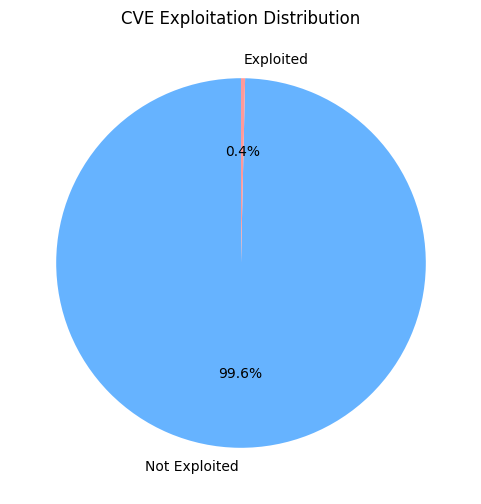


========== CLEANING DATA ==========
Original shape: (8153, 22)

Original vuln_status counts:
vuln_status
Analyzed               3959
Awaiting Analysis      2866
Modified               1031
Rejected                294
Undergoing Analysis       3
Name: count, dtype: int64

Original exploited label counts:
exploited
0    8124
1      29
Name: count, dtype: int64

Cleaned shape: (4993, 22)

Cleaned vuln_status counts:
vuln_status
Analyzed               3959
Modified               1031
Undergoing Analysis       3
Name: count, dtype: int64

Cleaned exploited label counts:
exploited
0    4964
1      29
Name: count, dtype: int64

Head of cleaned dataframe:
           cve_id               published           last_modified vuln_status  \
0  CVE-2024-47475 2025-01-06 17:15:37.423 2025-01-09 16:04:01.680    Analyzed   
1  CVE-2024-56761 2025-01-06 17:15:41.480 2025-01-09 16:16:23.667    Modified   
2  CVE-2024-43063 2025-01-06 11:15:08.930 2025-01-10 15:37:33.340    Analyzed   
3  CVE-2024-33061 2

In [14]:
def main():

    # 1. Data Colletion
    kev_ids, kev_df = load_cisa_kev()

    # The maximum allowable range when using any date range parameters is 120 consecutive days. Also, max result per page is 2000
    cve_df = fetch_cves("2025-01-01","2025-02-28",2000,"a264b5f4-4416-4670-ab78-00258dcb0e72")

    # 2. Processing
    flatten_cve_df = flatten_cve(cve_df)

    # 3. Label the data
    labelled_cve_df = label_cve_data(flatten_cve_df, kev_ids)

    # 4. Cleaning
    # Before cleaning
    print("\n========== CLEANING DATA ==========")
    print("Original shape:", labelled_cve_df.shape)
    print("\nOriginal vuln_status counts:")
    print(labelled_cve_df['vuln_status'].value_counts())
    print("\nOriginal exploited label counts:")
    print(labelled_cve_df['exploited'].value_counts())

    # Clean the whole dataset (~2000 records)
    clean_df = clean_cve_dataset(labelled_cve_df)

    # After cleaning
    print("\nCleaned shape:", clean_df.shape)
    print("\nCleaned vuln_status counts:")
    print(clean_df['vuln_status'].value_counts())
    print("\nCleaned exploited label counts:")
    print(clean_df['exploited'].value_counts())

    # Quick peek
    print("\nHead of cleaned dataframe:")
    print(clean_df.head())

    # 5. Feature Engineering
    print("\n========== FEATURE ENGINEERING ==========")
    X, y, tfidf, numeric_cols = engineer_features(clean_df)

    print("\nFeature matrix shape (X):", X.shape)   # (n_samples, n_features)
    print("Number of labels (y):", len(y))        # n_samples

    # 6. Temporal train/test split
    train_df, test_df = temporal_train_test_split(clean_df)

     # 7. Prepare train/test features (subset from full feature matrix)
    train_idx = clean_df[clean_df['cve_id'].isin(train_df['cve_id'])].index
    test_idx = clean_df[clean_df['cve_id'].isin(test_df['cve_id'])].index

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    # 8. Train model
    model, y_pred, y_pred_proba = train_model(X_train, y_train, X_test, y_test)

    # 9. Evaluate
    metrics = evaluate_model(model, X_test, y_test, y_pred_proba)

    # 10. Feature importance
    show_top_features(model, tfidf, numeric_cols)

    # 11. Save model
    model_path = save_model(model, tfidf, numeric_cols)

    # 12. High-risk predictions
    results = predict_new_cves(model, tfidf, numeric_cols, test_df)
    print("\nTop 10 Highest Risk CVEs (Test Set):")
    print(results.head(10)[['cve_id', 'exploitation_probability', 'risk_score']].to_csv(index=False))


    # Return everything you’ll likely need later
    return clean_df, X, y, tfidf, numeric_cols, labelled_cve_df, model, metrics, results, model_path

    #X, y, tfidf = generate_features(df)

    #X_train, X_test, y_train, y_test = temporal_split(df, X, y)

   # X_train, y_train = balance_data(X_train, y_train)

    #model = train_model(X_train, y_train)

    #evaluate_model(model, X_test, y_test)

    #show_top_features(model, tfidf)

    #save_files(model, tfidf)


if __name__ == "__main__":
    clean_df, X, y, tfidf, numeric_cols, labelled_cve_df, model, metrics, results, model_path  = main()

In [15]:
clean_df.head()

,cve_id,published,last_modified,vuln_status,cvss_version,cvss_score,cvss_severity,cvss_vector,exploitability_score,impact_score,...,affected_vendors,affected_products,affected_versions,references_count,references_exploit_count,references_patch_count,references_vendor_advisory_count,has_exploit_tag,description,exploited
0,CVE-2024-47475,2025-01-06 17:15:37.423,2025-01-09 16:04:01.680,Analyzed,None,None,None,None,None,None,...,None,None,None,1,0,0,1,0,Dell PowerScale OneFS 8.2.2.x through 9.8.0.x ...,0
1,CVE-2024-56761,2025-01-06 17:15:41.480,2025-01-09 16:16:23.667,Modified,None,None,None,None,None,None,...,None,None,None,3,0,2,0,0,"In the Linux kernel, the following vulnerabili...",0
2,CVE-2024-43063,2025-01-06 11:15:08.930,2025-01-10 15:37:33.340,Analyzed,None,None,None,None,None,None,...,None,None,None,1,0,0,1,0,information disclosure while invoking the mail...,0
3,CVE-2024-33061,2025-01-06 11:15:08.617,2025-01-10 16:49:42.207,Analyzed,None,None,None,None,None,None,...,None,None,None,1,0,1,1,0,Information disclosure while processing IOCTL ...,0
4,CVE-2024-33059,2025-01-06 11:15:08.470,2025-01-10 16:53:02.590,Analyzed,None,None,None,None,None,None,...,None,None,None,1,0,1,1,0,Memory corruption while processing frame comma...,0


## TRAIN/TEST

###### Please remove this line. It is for the next person's reference - Use 'clean_df' to proceed for further analysis